In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim

from tensorflow.contrib.layers import *
%matplotlib inline

In [2]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

# Modules

In [3]:
# Discriminator
def D(x,h_dim=256,reuse=False):
    
    with tf.variable_scope('D',reuse=reuse):
        
        fc1 = fully_connected(inputs=x,  num_outputs=h_dim,activation_fn=tf.nn.relu)
        fc2 = fully_connected(inputs=fc1,num_outputs=h_dim,activation_fn=tf.nn.relu)
        fc3 = fully_connected(inputs=fc2,num_outputs=h_dim,activation_fn=tf.nn.relu)
        logits = fully_connected(inputs=fc3,num_outputs=1, activation_fn=None)
        out = tf.sigmoid(logits)
        
        return out, logits


# generator
def G(z, is_training,h_dim=128, reuse=False):
    
    with tf.variable_scope('G',reuse=reuse):
        
#         with slim.arg_scope([slim.conv2d, slim.fully_connected],
#                     activation_fn=tf.nn.leaky_relu,
#                     normalizer_fn=tf.layers.batch_normalization,
#                     normalizer_params={'training': is_training, 'momentum': 0.95}):


        fc1 = fully_connected(inputs=z,  num_outputs=h_dim,activation_fn=tf.nn.leaky_relu)
        fc2 = fully_connected(inputs=fc1,num_outputs=h_dim,activation_fn=tf.nn.leaky_relu)
        out = fully_connected(inputs=fc2,num_outputs=2, activation_fn=tf.nn.tanh)

        return out


# Statistics network for MINE
def M(inp,h_dim=128, reuse=False):
    
    with tf.variable_scope('M',reuse=reuse):
        
        fc1 = fully_connected(inputs=inp,num_outputs=h_dim,activation_fn=tf.nn.elu)
        fc2 = fully_connected(inputs=fc1,num_outputs=h_dim,activation_fn=tf.nn.elu)
        fc3 = fully_connected(inputs=fc2,num_outputs=h_dim,activation_fn=tf.nn.elu)
        out = fully_connected(inputs=fc3,num_outputs=1, activation_fn=None)
    
        return out

# computational graph

In [4]:
noise_dim = 6
code_dim  = 4

tf.reset_default_graph()

x_real = tf.placeholder(tf.float32,shape=[None,2],name='x_real')
eps    = tf.placeholder(tf.float32,shape=[None,noise_dim],name='eps')
code   = tf.placeholder(tf.float32,shape=[None,code_dim],name='code')
is_training = tf.placeholder(tf.bool,shape=[],name='is_training')

# generator
z = tf.concat([eps,code], axis=1)
x_tld = G(z, is_training)

# discriminator
D_out_real, D_log_real = D(x_real)
D_out_fake, D_log_fake = D(x_tld,reuse=True)


# mine
c_bar = tf.random_shuffle(code)

joint = tf.concat([code,x_tld], axis=1)
margn = tf.concat([c_bar,x_tld], axis=1)

t  = M(joint)
et = tf.exp(M(margn,reuse=True))



In [5]:
# print variables in graph
l = [x.name for x in tf.global_variables()]

for ll in l:
    print(ll)

G/fully_connected/weights:0
G/fully_connected/biases:0
G/fully_connected_1/weights:0
G/fully_connected_1/biases:0
G/fully_connected_2/weights:0
G/fully_connected_2/biases:0
D/fully_connected/weights:0
D/fully_connected/biases:0
D/fully_connected_1/weights:0
D/fully_connected_1/biases:0
D/fully_connected_2/weights:0
D/fully_connected_2/biases:0
D/fully_connected_3/weights:0
D/fully_connected_3/biases:0
M/fully_connected/weights:0
M/fully_connected/biases:0
M/fully_connected_1/weights:0
M/fully_connected_1/biases:0
M/fully_connected_2/weights:0
M/fully_connected_2/biases:0
M/fully_connected_3/weights:0
M/fully_connected_3/biases:0


# loss function

In [6]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

# ----- D ----- #
D_real_loss=loss_func(D_log_real,tf.ones_like(D_log_real)*0.9) #Smoothing for generalization
D_fake_loss=loss_func(D_log_fake,tf.zeros_like(D_log_real))
D_loss = D_real_loss + D_fake_loss

# ----- M ----- #
M_loss = -(tf.reduce_mean(t) - tf.log(tf.reduce_mean(et)))

# ----- G ----- #
G_loss = loss_func(D_log_fake,tf.ones_like(D_log_fake)) #+ M_loss




# optimizers

In [7]:
lr = 1e-4


tvars=tf.trainable_variables() 

d_vars=[var for var in tvars if 'D' in var.name]
g_vars=[var for var in tvars if 'G' in var.name]
m_vars=[var for var in tvars if 'M' in var.name]

D_train_op=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
M_train_op_m=tf.train.AdamOptimizer(lr).minimize(M_loss,var_list=m_vars)
M_optimizer = tf.train.AdamOptimizer(lr)
G_optimizer=tf.train.AdamOptimizer(lr)
# M_trainer=tf.train.AdamOptimizer(lr).minimize(M_loss,var_list=m_vars)

In [8]:
batch_size=256
epochs=100


# Gradient clipping

In [9]:
ggu = tf.gradients(G_loss, g_vars)
ggm = tf.gradients(M_loss, g_vars)

# ga = [] 
for i, (gu,gm) in enumerate(zip(ggu,ggm)):

    # clip
    gu_ = tf.norm(gu)
    gm_ = tf.norm(gm)
    g_ =  tf.minimum(gu_, gm_)

    ggm[i]=tf.multiply(g_,tf.divide(gm,gm_))

ga_and_vars = list(zip(ggm, g_vars))
M_train_op_g = M_optimizer.apply_gradients(grads_and_vars=ga_and_vars)

ggu_and_vars = list(zip(ggu,g_vars))
G_train_op=G_optimizer.apply_gradients(grads_and_vars=ggu_and_vars)




# Make toy data

In [10]:
x = 0.2 * np.random.randn(20000, 2)

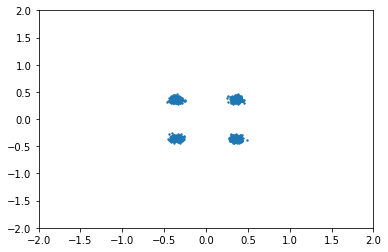

In [11]:
x = np.array([(i,j) for i in range(-4, 5, 6) for j in range(-4, 5, 6)] * 5000)
x = x + 0.3 * np.random.randn(*x.shape)

x = (x - np.amin(x))/(np.amax(x) - np.amin(x)) - 0.5

# shuffle
np.random.shuffle(x)
plt.scatter(x[:1000,0], x[:1000,1], s=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.show()

In [12]:
n_samples = x.shape[0]
num_batches = n_samples//batch_size

ep:0, D_real_loss: 0.6994, D_fake_loss: 0.5992, D_out_fk: 0.4477,D_out_rl: 0.5004, G_loss: 0.8109, M_loss: 0.0904


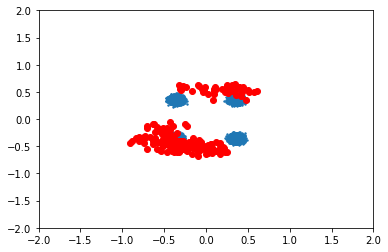

ep:1, D_real_loss: 0.8652, D_fake_loss: 0.3975, D_out_fk: 0.3245,D_out_rl: 0.4119, G_loss: 1.1438, M_loss: 0.5217
ep:2, D_real_loss: 0.7747, D_fake_loss: 0.3384, D_out_fk: 0.2836,D_out_rl: 0.4583, G_loss: 1.2937, M_loss: 0.9513
ep:3, D_real_loss: 0.7144, D_fake_loss: 0.4438, D_out_fk: 0.3399,D_out_rl: 0.5039, G_loss: 1.2122, M_loss: 0.8141
ep:4, D_real_loss: 0.8027, D_fake_loss: 0.5976, D_out_fk: 0.4451,D_out_rl: 0.4394, G_loss: 0.8232, M_loss: 0.9808
ep:5, D_real_loss: 0.7772, D_fake_loss: 0.5999, D_out_fk: 0.4492,D_out_rl: 0.4515, G_loss: 0.8062, M_loss: 1.2914
ep:6, D_real_loss: 0.7520, D_fake_loss: 0.6415, D_out_fk: 0.4734,D_out_rl: 0.4651, G_loss: 0.7482, M_loss: 1.1861
ep:7, D_real_loss: 0.7731, D_fake_loss: 0.5907, D_out_fk: 0.4456,D_out_rl: 0.4537, G_loss: 0.8098, M_loss: 1.2330
ep:8, D_real_loss: 0.8082, D_fake_loss: 0.5622, D_out_fk: 0.4299,D_out_rl: 0.4341, G_loss: 0.8446, M_loss: 1.5023
ep:9, D_real_loss: 0.7723, D_fake_loss: 0.6141, D_out_fk: 0.4588,D_out_rl: 0.4536, G_los

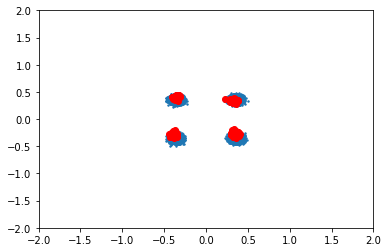

ep:11, D_real_loss: 0.8178, D_fake_loss: 0.5705, D_out_fk: 0.4345,D_out_rl: 0.4292, G_loss: 0.8344, M_loss: 1.5427
ep:12, D_real_loss: 0.7787, D_fake_loss: 0.6107, D_out_fk: 0.4565,D_out_rl: 0.4502, G_loss: 0.7854, M_loss: 1.3501
ep:13, D_real_loss: 0.7528, D_fake_loss: 0.6154, D_out_fk: 0.4595,D_out_rl: 0.4645, G_loss: 0.7778, M_loss: 1.3648
ep:14, D_real_loss: 0.8164, D_fake_loss: 0.5649, D_out_fk: 0.4316,D_out_rl: 0.4297, G_loss: 0.8404, M_loss: 1.4009
ep:15, D_real_loss: 0.7692, D_fake_loss: 0.6278, D_out_fk: 0.4661,D_out_rl: 0.4552, G_loss: 0.7635, M_loss: 1.3731
ep:16, D_real_loss: 0.7525, D_fake_loss: 0.6134, D_out_fk: 0.4581,D_out_rl: 0.4653, G_loss: 0.7818, M_loss: 1.1228
ep:17, D_real_loss: 0.8265, D_fake_loss: 0.5471, D_out_fk: 0.4212,D_out_rl: 0.4247, G_loss: 0.8652, M_loss: 1.4950
ep:18, D_real_loss: 0.7524, D_fake_loss: 0.6419, D_out_fk: 0.4736,D_out_rl: 0.4649, G_loss: 0.7476, M_loss: 1.2469
ep:19, D_real_loss: 0.7641, D_fake_loss: 0.6133, D_out_fk: 0.4583,D_out_rl: 0.45

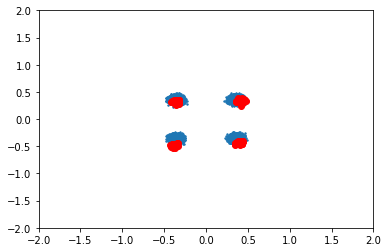

KeyboardInterrupt: 

In [13]:
samples=[] #generator examples

init=tf.global_variables_initializer()

# with tf.Session() as sess:
sess=tf.Session()
sess.run(init)


for epoch in range(10000):

    perm = np.random.permutation(n_samples)

    for i in range(num_batches):

        batch_x    = x[i*batch_size:(i+1)*(batch_size)]
        batch_eps  = np.random.uniform(-1., 1., size=[batch_size,noise_dim])#np.random.randn(batch_size,noise_dim)

        categorical_code = np.random.randint(0,code_dim,size=batch_size)
        batch_code = indices_to_one_hot(categorical_code,code_dim)


        feed_dict = {x_real:batch_x, eps:batch_eps, code:batch_code, is_training:True}

        sess.run(D_train_op,feed_dict)
        sess.run(G_train_op,feed_dict)
        sess.run(M_train_op_m,feed_dict)
        sess.run(M_train_op_g,feed_dict)


    D_real,D_fake,D_outF,D_outR,g_loss,m_loss = sess.run([D_real_loss,D_fake_loss,D_out_fake,D_out_real,G_loss,M_loss],\
                                           feed_dict)
    print("ep:{}, D_real_loss: {:0.4f}, D_fake_loss: {:0.4f}, D_out_fk: {:0.4f},D_out_rl: {:0.4f}, G_loss: {:0.4f}, M_loss: {:0.4f}".format(epoch,D_real,D_fake,np.mean(D_outF),np.mean(D_outR),g_loss,-m_loss))


    sample_eps = np.random.uniform(-1,1,size=(200,noise_dim))
    aa = np.random.randint(0,code_dim,size=200)
    sample_cod = indices_to_one_hot(aa,code_dim)

    gen_sample = sess.run(x_tld,feed_dict={eps:sample_eps, code:sample_cod, is_training:True})

    if epoch%10 == 0:
        plt.scatter(x[:,0], x[:,1], s=2.0)
        plt.scatter(gen_sample[:,0],gen_sample[:,1],c='r')
        plt.xlim((-2, 2))
        plt.ylim((-2, 2))
        plt.show()

        #samples.append(gen_sample)

In [ ]:

    
sample_eps = np.random.uniform(-1,1,size=(200,noise_dim))
aa = 3*np.ones(200, dtype=int)#np.random.randint(0,code_dim,size=200)
sample_cod = indices_to_one_hot(aa,code_dim)

gen_sample = sess.run(x_tld,feed_dict={eps:sample_eps, code:sample_cod, is_training:True})


plt.scatter(x[:,0], x[:,1], s=2.0)
plt.scatter(gen_sample[:,0],gen_sample[:,1],c='r')
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.show()

In [ ]:
aa